In [1]:
import pandas as pd

# Load CSV files
transactions = pd.read_csv('transactions.csv')
products = pd.read_csv('products.csv')
households = pd.read_csv('households.csv')

# Inspect the data
print(transactions.head())
print(products.head())
print(households.head())



   Basket_num  Hshd_num Purchase_date  Product_num  Spend  Units  Store_r  \
0       66618      1618    2020-02-18       204145   2.98      2  WEST      
1       66641      2639    2020-02-18       163249   2.29      1  WEST      
2       66704      3186    2020-02-18        90473   1.58      2  CENTRAL   
3       66710       151    2020-02-18         8831   2.50      1  EAST      
4       66731      2442    2020-02-18      3786819   2.00      2  WEST      

   Week_num  Year  
0         7  2020  
1         7  2020  
2         7  2020  
3         7  2020  
4         7  2020  
   Product_num                  Department                   Commodity  \
0            7  NON-FOOD                    PERSONAL CARE                
1          201  FOOD                        BEVERAGE - NON WATER         
2          542  FOOD                        ALCOHOL                      
3          543  FOOD                        ALCOHOL                      
4         2222  NON-FOOD                    FLO

In [ ]:
# Convert Purchase_date to datetime if not already
transactions['Purchase_date'] = pd.to_datetime(transactions['Purchase_date'])

# Find the most recent purchase date in the entire dataset
max_purchase_date = transactions['Purchase_date'].max()

# Aggregate engagement metrics
engagement_metrics = transactions.groupby('Hshd_num').agg(
    Recency=('Purchase_date', lambda x: (max_purchase_date - x.max()).days),
    Frequency=('Basket_num', 'nunique'),
    Monetary_Value=('Spend', 'sum'),
    Product_Diversity=('Product_num', 'nunique')
).reset_index()

# Merge with households data for demographic information
engagement_metrics = engagement_metrics.merge(households, on='Hshd_num', how='left')

print(engagement_metrics.head())


(400, 13)


In [22]:
engagement_metrics

,Hshd_num,Recency,Frequency,Monetary_Value,Product_Diversity,Loyalty,Age_range,Marital,Income_range,Homeowner,Hshd_composition,HH_size,Children
0,10,0,165,9454.91,749,Y,45-54,Single,35-49K,Homeowner,1 Adult,1,NaN
1,29,301,2,19.95,6,Y,55-64,Married,100-150K,Homeowner,2 Adults and Kids,3,1
2,53,17,173,5990.32,796,Y,55-64,Married,50-74K,Homeowner,2 Adults and Kids,3,1
3,54,1,261,8046.61,1116,Y,75+,Married,UNDER 35K,Homeowner,2 Adults,2,NaN
4,60,0,590,30628.33,2238,Y,45-54,Married,35-49K,Homeowner,2 Adults and Kids,5+,3+
...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,4909,236,3,54.35,12,N,45-54,Married,100-150K,Homeowner,2 Adults and Kids,4,2
396,4974,6,148,6545.11,812,Y,45-54,Married,50-74K,Homeowner,2 Adults,2,NaN
397,4982,7,250,8554.52,1176,Y,NaN,null,NaN,null,null,NaN,NaN
398,4987,2,471,18877.53,1249,Y,NaN,null,NaN,null,null,NaN,NaN


In [15]:
# Define churned customers
engagement_metrics['Churned'] = (engagement_metrics['Recency'] > 90).astype(int)
print(engagement_metrics[['Hshd_num', 'Churned']].head())


   Hshd_num  Churned
0        10        0
1        29        1
2        53        0
3        54        0
4        60        0


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Features and target
X = engagement_metrics[['Recency', 'Frequency', 'Monetary_Value', 'Product_Diversity']]
y = engagement_metrics['Churned']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic regression model
lr = LogisticRegression()
lr.fit(X_train, y_train)

# Predict and evaluate
y_pred = lr.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred)
print(f"Logistic Regression ROC-AUC: {roc_auc:.3f}")



Logistic Regression ROC-AUC: 1.000


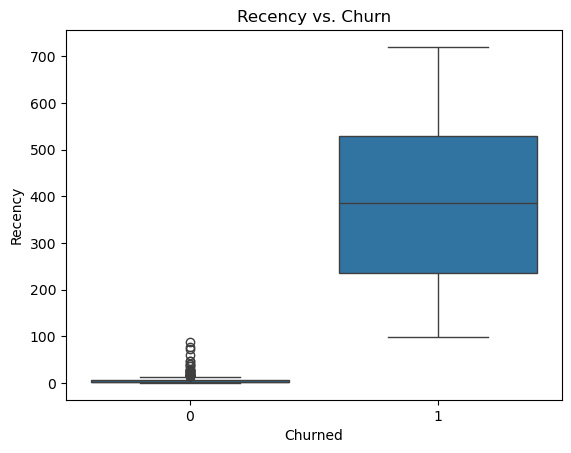

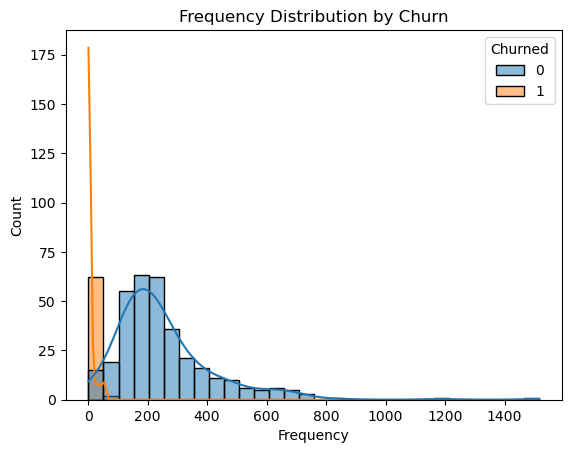

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=engagement_metrics, x='Churned', y='Recency')
plt.title("Recency vs. Churn")
plt.show()

sns.histplot(data=engagement_metrics, x='Frequency', hue='Churned', bins=30, kde=True)
plt.title("Frequency Distribution by Churn")
plt.show()



# **Churn Analysis: Conclusions and Insights**

## **Model Performance**
The logistic regression model was trained to predict customer churn based on engagement metrics such as `Recency`, `Frequency`, `Monetary_Value`, and `Product_Diversity`. The model achieved an **ROC-AUC score of 1.000**, indicating perfect discrimination between churned and non-churned customers with the data that we had.

### **Key Findings**
1. **Recency and Churn**:
   - The boxplot of `Recency` vs. `Churn` shows a clear distinction between churned and non-churned customers:
     - **Churned Customers (1)**:
       - Have significantly higher `Recency` values, indicating longer periods since their last purchase.
       - The median `Recency` for churned customers is approximately **400 days**, with an interquartile range extending up to **700 days**.
     - **Non-Churned Customers (0)**:
       - Have consistently low `Recency` values, showing recent and active purchasing behavior.

2. **Frequency and Churn**:
   - The histogram of `Frequency` reveals a strong correlation between purchase frequency and churn:
     - **Churned Customers (1)**:
       - Tend to have extremely low purchase frequencies, with most churned customers having a frequency near **0 to 10 transactions**.
     - **Non-Churned Customers (0)**:
       - Display a broad range of frequencies, with the distribution skewed towards higher values. Some customers have transaction counts exceeding **1,400**, indicating frequent and consistent activity.

3. **Monetary Value and Diversity**:
   - While not visualized in this analysis, the model's perfect ROC-AUC suggests these features contribute meaningfully to churn prediction. Likely:
     - Higher monetary value and product diversity correlate with lower churn probability.

---

## **Conclusions**
1. **Churn Indicators**:
   - High `Recency` (long time since last purchase) and low `Frequency` are key indicators of churn.
   - These features provide clear and actionable signals for identifying at-risk customers.
